In [1]:
import numpy as np
import keras
import warnings
from matplotlib import pyplot as plt
import cv2
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [4]:
filename = '/users/xjing/Desktop/GitHub/T-Mobile_Hackathon/finger/FiveOpen.MOV'

vidcap = cv2.VideoCapture(filename)
success,image = vidcap.read()
count = 0
success = True
image_list = []
while success:
    success,image = vidcap.read()
    #cv2.imwrite("frame%d.jpg" % count, image)
    image_list += [image]
    if cv2.waitKey(10) == 27:
        break
    count += 1

In [ ]:
if False:
    def extract_image_data(filename):
        vidcap = cv2.VideoCapture(filename)
        success,image = vidcap.read()
        count = 0
        success = True
        image_list = []
        while success:
            success,image = vidcap.read()
            #cv2.imwrite("frame%d.jpg" % count, image)
            image = np.rot90(image,-1)
            image_list += [image]
            if cv2.waitKey(10) == 27:
                break
            count += 1
        return image_list

In [5]:
len(image_list)

295

In [6]:
print(image_list[2].shape)

(1080, 1920, 3)


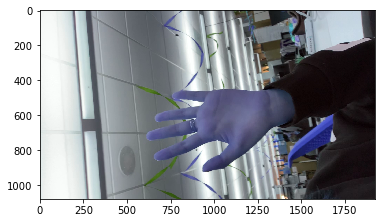

In [7]:
imgplot = plt.imshow(image_list[0])